In [ ]:
!unzip assessment_dataset.zip

Archive:  assessment_dataset.zip
   creating: assessment_dataset/
  inflating: assessment_dataset/category_mapping.json  
   creating: assessment_dataset/images/
  inflating: assessment_dataset/images/10014.jpg  
  inflating: assessment_dataset/images/10070.jpg  
  inflating: assessment_dataset/images/10092.jpg  
  inflating: assessment_dataset/images/10093.jpg  
  inflating: assessment_dataset/images/10117.jpg  
  inflating: assessment_dataset/images/10141.jpg  
  inflating: assessment_dataset/images/10176.jpg  
  inflating: assessment_dataset/images/10183.jpg  
  inflating: assessment_dataset/images/10200.jpg  
  inflating: assessment_dataset/images/10219.jpg  
  inflating: assessment_dataset/images/10255.jpg  
  inflating: assessment_dataset/images/10265.jpg  
  inflating: assessment_dataset/images/10269.jpg  
  inflating: assessment_dataset/images/10300.jpg  
  inflating: assessment_dataset/images/10308.jpg  
  inflating: assessment_dataset/images/10335.jpg  
  inflating: assessmen

## Part 1: Exploratory Data Analysis
Here, we will explore the structure of the dataset. In particular, we will examine the distribution of classes, the pixel resolution of the training instances as well as the range of color values. For simplicity, we will only focus on the raw images and the master category.

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

'''
Using Pandas to load the training data CSV file,
containing the image ID along with the associated
master category. We drop all of the extra attributes.
'''

train_df_raw = pd.read_csv('assessment_dataset/train.csv')
train_df = train_df_raw.drop(columns=[
    'gender', 'subCategory', 'articleType', 'baseColour',
    'season', 'year', 'usage', 'productDisplayName'])

print(train_df)

categories = train_df['masterCategory'].unique()

         id masterCategory
0     24218       Footwear
1     59326       Footwear
2      2387       Footwear
3     36482       Footwear
4      9102       Footwear
...     ...            ...
1045  31971       Footwear
1046  42683        Apparel
1047  11133    Accessories
1048   2784        Apparel
1049   2885       Footwear

[1050 rows x 2 columns]


In [ ]:
import cv2

# Convert image IDs and categories to lists for easier processing.

train_ids = train_df['id'].to_list()
train_categories = train_df['masterCategory'].to_list()

category_count = {k: 0 for k in categories}
for cat in train_categories:
  category_count[cat] += 1

# Count number of training images and distribution of training instances

print(f"Number of training images: {len(train_ids)}")
print(f"Distribution of images: {category_count}")
print("")

train_ds = []
for img_name in train_ids:
  img = cv2.imread(f'assessment_dataset/images/{img_name}.jpg', cv2.IMREAD_COLOR_RGB)
  train_ds.append(img)

# Inspect size of training instances as well as minimum and maximum pixel values

train_ds = np.array(train_ds)
print(f"Size of training images: {train_ds.shape[1:]}")

min_color = np.min(train_ds)
max_color = np.max(train_ds)
print(f"Min pixel value: {min_color}")
print(f"Max pixel value: {max_color}")

Number of training images: 1050
Distribution of images: {'Footwear': 385, 'Apparel': 393, 'Accessories': 227, 'Personal Care': 42, 'Free Items': 3}

Size of training images: (224, 224, 3)
Min pixel value: 0
Max pixel value: 255


[Footwear]


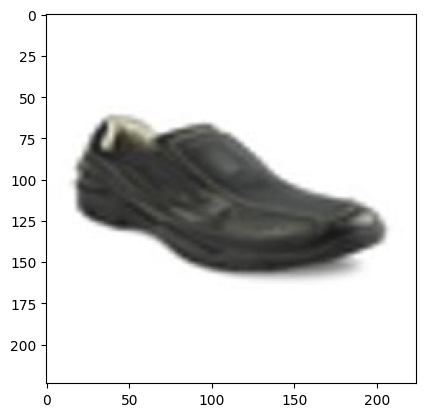

[Apparel]


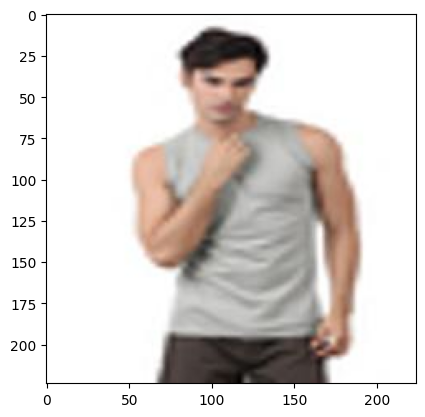

In [ ]:
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

# Visualize instances of two different categories

plt.imshow(train_ds[2])
print(f"[{train_categories[2]}]")
plt.show()

plt.imshow(train_ds[454])
print(f"[{train_categories[454]}]")
plt.show()

### Observations
The size of the training images is 224x224 pixels. They each have 3 channels of red, blue and green. The minimum value of pixels is 0/black, and the maximum value is 255/white. Visualizing the training instances, we can see that footwear and apparel have very different contents within the images. Training data distribution-wise, both 'Personal Care' and 'Free Items' categories have the least training instances, while 'Footwear', 'Apparel' and 'Accessories' have the greatest number of training instances.

# Part 2: Feature Engineering
Here, we will explore two ways of extracting meaningful features from the raw image pixels, namely SIFT and SqueezeNet features.

[Footwear with SIFT Keypoints]


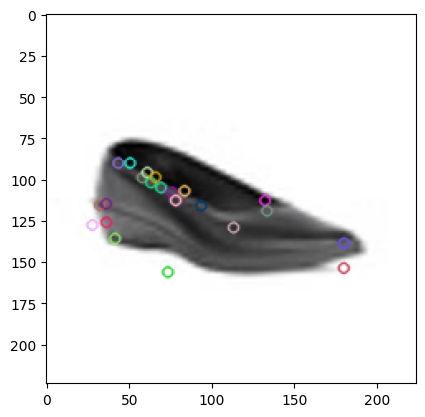

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


torch.Size([1, 3, 224, 224])


100%|██████████| 4.73M/4.73M [00:00<00:00, 52.2MB/s]


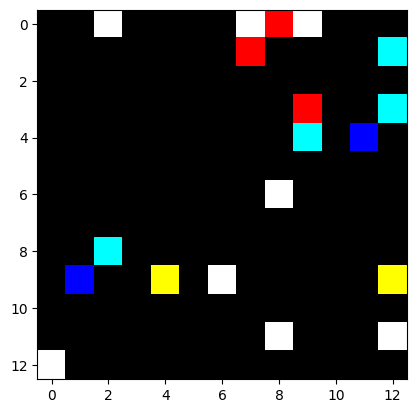

In [ ]:
from PIL import Image
from torchvision.models import squeezenet1_1, SqueezeNet1_1_Weights
import torchvision.transforms.functional as TF

### SIFT Feature Extraction

sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
keypoints, descriptors = sift.detectAndCompute(train_ds[1], None)

# Draw the keypoints on the image
img_with_keypoints = cv2.drawKeypoints(train_ds[1], keypoints, None)

plt.imshow(img_with_keypoints)
print(f"[{train_categories[1]} with SIFT Keypoints]")
plt.show()

### SqueezeNet Feature Extraction using ImageNet pretrained weights
# We use the convolutional feature network to extract reasonably meaningful
# features from the input image.

img_tensor = TF.to_tensor(train_ds[1]).unsqueeze(0)
print(img_tensor.shape)
net = squeezenet1_1(weights=SqueezeNet1_1_Weights.IMAGENET1K_V1)

features = net.features(img_tensor).squeeze(0)
features_np = features.view(features.size(1), features.size(2), features.size(0)).detach().numpy()

plt.imshow(features_np[:, :, :3])
plt.show()

# Part 3: Model Development
Here we will attempt three different approaches to training an image classifier:
- A classifier that uses features from the pretrained SqueezeNet as a fixed feature extractor.
- A fine-tuned SqueezeNet classifier (same as above, but now the feature network is also trained)
- Every other parameter in the SqueezeNet is trainable (hybrid of the two above)

In [ ]:
# Create dataloader

import torch
from torch.utils.data import DataLoader, TensorDataset

## Loading test data

test_df_raw = pd.read_csv('assessment_dataset/test.csv')
test_df = test_df_raw.drop(columns=[
    'gender', 'subCategory', 'articleType', 'baseColour',
    'season', 'year', 'usage', 'productDisplayName'])
test_ids = test_df['id'].to_list()

test_ds = []
for img_name in test_ids:
  img = cv2.imread(f'assessment_dataset/images/{img_name}.jpg', cv2.IMREAD_COLOR_RGB)
  test_ds.append(img)

test_ds = np.array(test_ds)

#############################

train_data_arr = []
for img in train_ds:
  img_tensor = TF.to_tensor(img).unsqueeze(0)
  train_data_arr.append(img_tensor)

train_data = torch.cat(train_data_arr, dim=0)
train_target_, labels = pd.factorize(train_df.drop(columns=['id']).masterCategory)
train_target = torch.from_numpy(train_target_)

train_dataset = TensorDataset(train_data, train_target)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#############################

test_data_arr = []
for img in test_ds:
  img_tensor = TF.to_tensor(img).unsqueeze(0)
  test_data_arr.append(img_tensor)

test_data = torch.cat(test_data_arr, dim=0)
test_target_, _ = pd.factorize(test_df.drop(columns=['id']).masterCategory)
test_target = torch.from_numpy(test_target_)

test_dataset = TensorDataset(test_data, test_target)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train loader batch number: {len(train_loader)}")
print(f"Test loader batch number: {len(test_loader)}")

Train loader batch number: 33
Test loader batch number: 15


In [ ]:
# Prepare all the training and testing code

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Main training loop
def train_clf(model, n_iters, device):
  learning_rate = 1e-4
  optimizer = Adam(model.parameters(), lr=learning_rate)
  print("===============================================================")
  for epoch in range(1, n_iters + 1):
    running_loss = 0.
    for x, y in train_loader:
      optimizer.zero_grad()
      x, y = x.to(device), y.to(device)
      pred_logits = model(x)
      loss = F.nll_loss(F.log_softmax(pred_logits, dim=1), y, reduction='mean')
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    print(f"[Epoch {epoch} loss] ----> {running_loss}")
  print("")

# Test with precision, recall and accuracy
def test_clf(model, device):
  with torch.no_grad():
    y_pred = []
    y_true = []
    for x, y in test_loader:
      x, y = x.to(device), y.to(device)
      pred_logits = model(x)
      pred_labels = torch.argmax(pred_logits, dim=1)
      for i in range(y.size(0)):
        y_pred.append(pred_labels[i].item())
        y_true.append(y[i].item())
    precision, recall, f1score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=np.nan)
    accuracy = accuracy_score(y_true, y_pred)
    print("===============================================================")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1score}")
    print(f"Accuracy: {accuracy}")
    print("")

    model_score = 0.25 * (precision + recall + f1score + accuracy) # hacky way to determine best model
    return (model_score, precision, recall, f1score, accuracy), (y_true, y_pred)

In [ ]:
# This is the main experiment
# ===========================

n_iters = 50 # Run each classifier for 50 iterations

# [Classifier 1] SqueezeNet classifier with fixed feature extractor

'''
Fix feature layers by freezing all layers and then creating a new
classifier layer
'''

clf1 = squeezenet1_1(weights=SqueezeNet1_1_Weights.IMAGENET1K_V1)
for params in clf1.parameters():
  params.requires_grad = False

dropout = 0.5
nclasses = len(labels)
final_conv = nn.Conv2d(512, nclasses, kernel_size=1)
clf1.classifier = nn.Sequential(nn.Dropout(p=dropout), final_conv, nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)))

clf1.to(device)
print("Classifier with SqueezeNet Fixed Feature Extractor")
train_clf(clf1, n_iters, device)
results1 = test_clf(clf1, device)

# [Classifier 2] Fine-tuning SqueezeNet classifier

'''
Nearly the same as above, but we allow all layers to be trained
'''

clf2 = squeezenet1_1(weights=SqueezeNet1_1_Weights.IMAGENET1K_V1)
final_conv = nn.Conv2d(512, nclasses, kernel_size=1)
clf2.classifier = nn.Sequential(nn.Dropout(p=dropout), final_conv, nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)))

clf2.to(device)
print("Fine-tuned SqueezeNet Classifier")
train_clf(clf2, n_iters, device)
results2 = test_clf(clf2, device)

# [Classifier 3] SqueezeNet classifier with every other parameter fixed

'''
A hybrid approach that combines Classifier 1 and Classifier 2 by
allowing only every other parameter to be trained.
'''

clf3 = squeezenet1_1(weights=SqueezeNet1_1_Weights.IMAGENET1K_V1)
for i, params in enumerate(clf3.parameters()):
  if i % 2 == 0:
    params.requires_grad = False

final_conv = nn.Conv2d(512, nclasses, kernel_size=1)
clf3.classifier = nn.Sequential(nn.Dropout(p=dropout), final_conv, nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)))

clf3.to(device)
print("Hybrid SqueezeNet Classifier")
train_clf(clf3, n_iters, device)
results3 = test_clf(clf3, device)

Classifier with SqueezeNet Fixed Feature Extractor
[Epoch 1 loss] ----> 47.58805185556412
[Epoch 2 loss] ----> 32.08704423904419
[Epoch 3 loss] ----> 24.865162312984467
[Epoch 4 loss] ----> 20.47096985578537
[Epoch 5 loss] ----> 17.647303462028503
[Epoch 6 loss] ----> 15.486794412136078
[Epoch 7 loss] ----> 13.388208851218224
[Epoch 8 loss] ----> 12.200930655002594
[Epoch 9 loss] ----> 10.969858855009079
[Epoch 10 loss] ----> 10.297064140439034
[Epoch 11 loss] ----> 9.636568188667297
[Epoch 12 loss] ----> 9.054147198796272
[Epoch 13 loss] ----> 8.544390611350536
[Epoch 14 loss] ----> 8.285012908279896
[Epoch 15 loss] ----> 7.759366624057293
[Epoch 16 loss] ----> 7.521866165101528
[Epoch 17 loss] ----> 7.284425899386406
[Epoch 18 loss] ----> 6.979815594851971
[Epoch 19 loss] ----> 6.747752644121647
[Epoch 20 loss] ----> 6.382936581969261
[Epoch 21 loss] ----> 6.352439105510712
[Epoch 22 loss] ----> 6.341296333819628
[Epoch 23 loss] ----> 6.016947448253632
[Epoch 24 loss] ----> 5.8806203

Best Classifier: Classifier #2


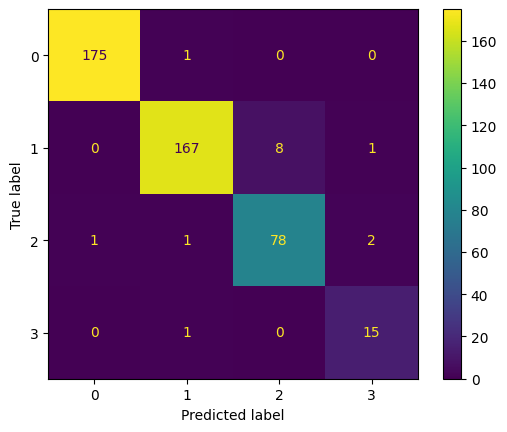

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

result_array = [results1, results2, results3]

best_score = 0
best_result = None
best_model_idx = -1
for i, result in enumerate(result_array):
  (scores, precision, recall, f1score, accuracy), (y_true, y_pred) = result
  if scores > best_score:
    best_score = scores
    best_result = result
    best_model_idx = i

print(f"Best Classifier: Classifier #{best_model_idx + 1}")

_, (y_true, y_pred) = best_result
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

In [ ]:
# Save predictions to CSV file

pred_columns = ['id', 'masterCategory']
pred_data = []

for i, pred in enumerate(y_pred):
  pred_data.append((test_ids[i], categories[pred]))

pred_df = pd.DataFrame(pred_data, columns=pred_columns)
pred_df.to_csv('test_predictions.csv', index=False)

# Part 4: Analysis & Reflection
All of the models performed very well at classification, especially the fixed feature extractor model. This is very surprising since the final classification layer of the model is actually just a single convolution layer whose outputs get flattened. I would have expected this particular model to perform significantly worse, but it seems that the features learned from the ImageNet features are very general.

The best performing model is unsurprisingly Classifier 2, which is fully fine-tuned. It is especially apparent by the significantly lower training losses compared to the other two models. However, it should be noted that having less trainable parameters makes training much faster, so in that case Classifier 1 (fixed feature extractor) is a solid choice where compute is limited and accuracy requirements are more lenient.

As far as classification difficulty is concerned, all of the models had great performance metrics. The winning model does not seem to have much difficulty in classifying the vast majority of classes correctly. However, it should be noted that two of the classes had very little samples in the training set, thus the distribution of correctly classified test data for those categories are much lower than the other signficantly more abundant categories (the "Free Items" class does not even appear in the test dataset). If given more time, I would particularly address this dataset imbalance issue, perhaps by using the auxiliary metadata provided in the CSV files.